# Pipeline for analyzing flow cytometry data

In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180703_FBconsttunetrip/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180703_FBconsttunetrip/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180710_FBconstrepeat/Plate1/')

date = '20180703'

allfiles = {}
strains = ['Plate1','Plate2','Plate3']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [3]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [4]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

/Users/andrewng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['SSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats]


In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,10,1000)


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be remov

In [8]:
#Define the rows

Econcind = range(8)
Pconcind = range(12)

Econc = list()
Pconc = list()

for j in range(7):
    Econc.append(round(30*0.5**j,2))

for i in range(11):
    Pconc.append(round(100*0.5**i,2))

Px = [round(100*0.5**i,2) for i in range(11)]

Econc.append(0)
Pconc.append(0)
Px.append(0)

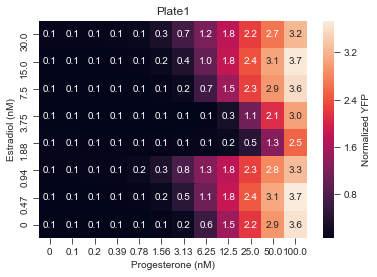

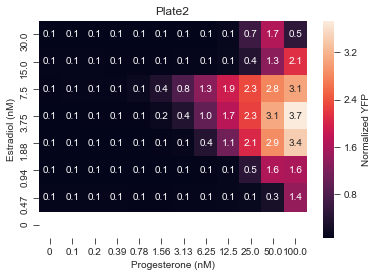

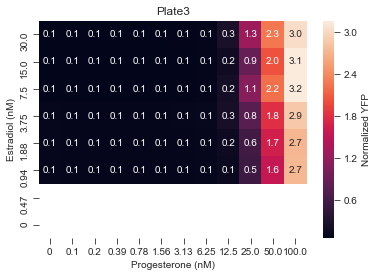

In [9]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

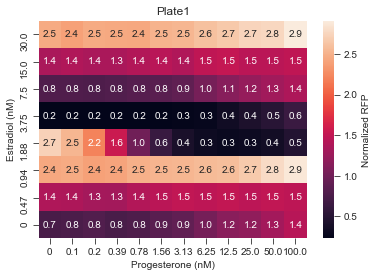

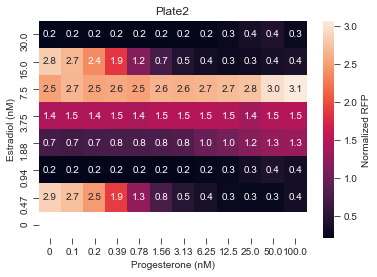

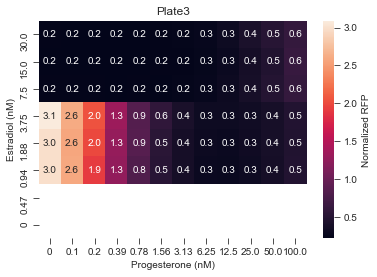

In [10]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

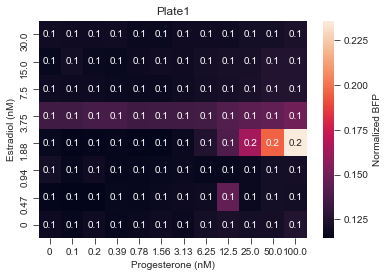

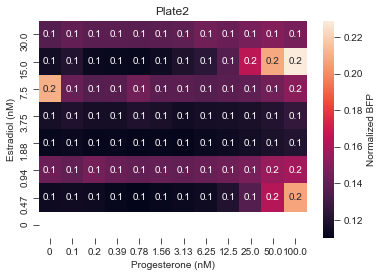

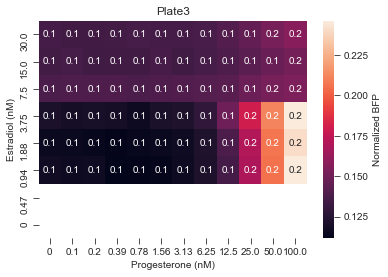

In [11]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

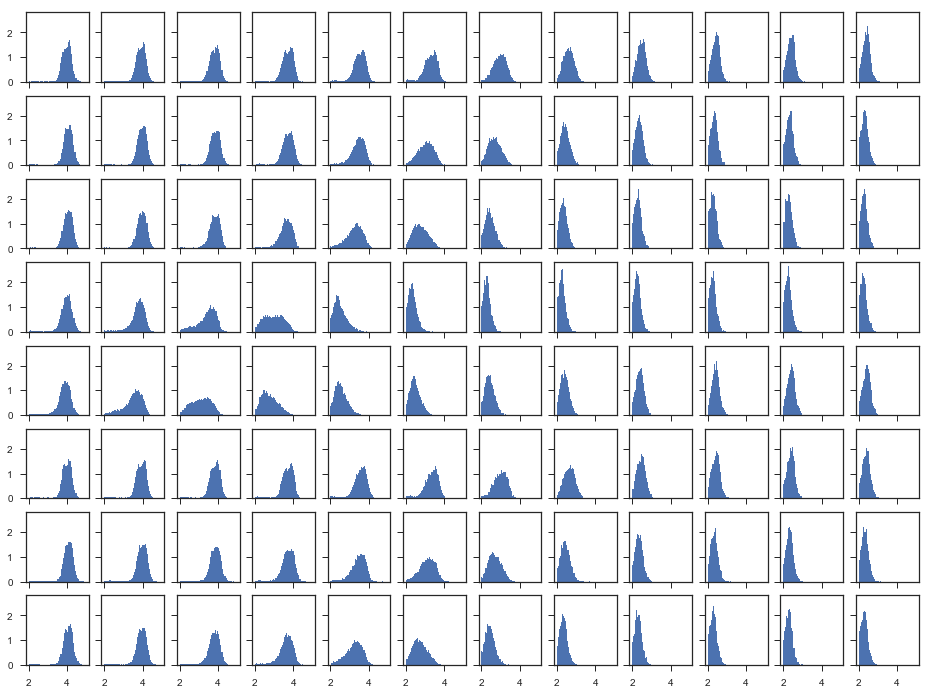

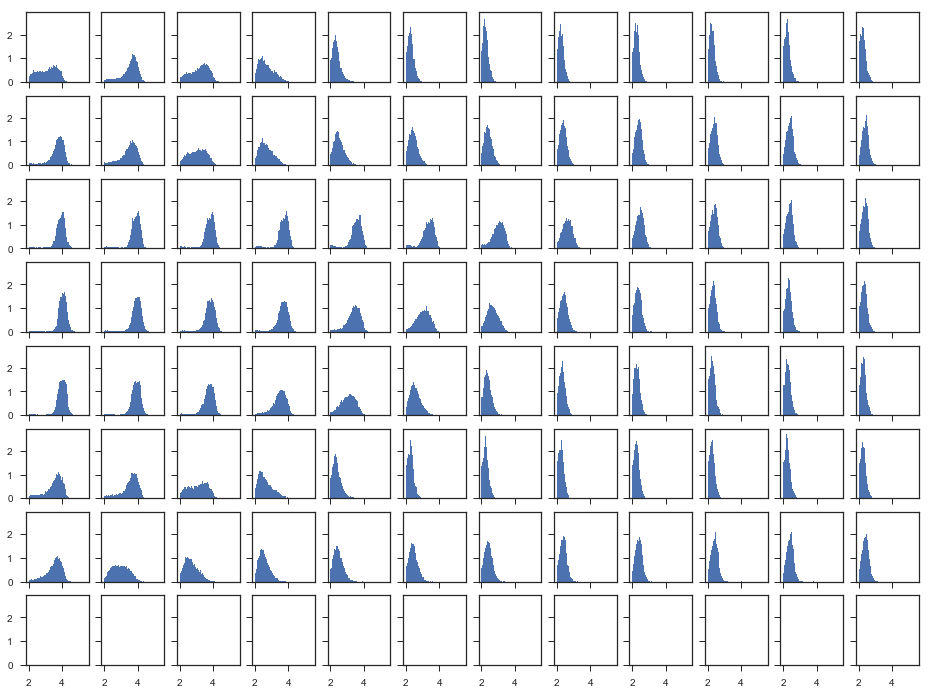

In [12]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=1)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [18]:
plt.set_cmap('plasma')

# Process data into array; compute averages and standard deviations

In [9]:
promoters = ['pREV1','pRNR2','pRET2','pRPL18B','CL']

In [10]:
#Average across the triplicate plates

FITCavg = pd.DataFrame(index = promoters, columns = cols)
RFPavg = pd.DataFrame(index = promoters, columns = cols)
BFPavg = pd.DataFrame(index = promoters, columns = cols)

FITCstd = pd.DataFrame(index = promoters, columns = cols)
RFPstd = pd.DataFrame(index = promoters, columns = cols)
BFPstd = pd.DataFrame(index = promoters, columns = cols)


for j, r in enumerate(promoters[0:3]):
    for i, c in enumerate(cols):
        FITCavg.set_value(r, c, np.mean([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate1'].med.iloc[j+5,i],FITCnorm['Plate2'].med.iloc[j+2,i]]))
        FITCstd.set_value(r, c, np.std([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate1'].med.iloc[j+5,i],FITCnorm['Plate2'].med.iloc[j+2,i]]))

        RFPavg.set_value(r, c, np.mean([RFPnorm['Plate1'].med.iloc[j,i],RFPnorm['Plate1'].med.iloc[j+5,i],RFPnorm['Plate2'].med.iloc[j+2,i]]))
        RFPstd.set_value(r, c, np.std([RFPnorm['Plate1'].med.iloc[j,i],RFPnorm['Plate1'].med.iloc[j+5,i],RFPnorm['Plate2'].med.iloc[j+2,i]]))

        BFPavg.set_value(r, c, np.mean([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate1'].med.iloc[j+5,i],BFPnorm['Plate2'].med.iloc[j+2,i]]))
        BFPstd.set_value(r, c, np.std([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate1'].med.iloc[j+5,i],BFPnorm['Plate2'].med.iloc[j+2,i]]))

for j, r in enumerate(promoters[3:5]):
    for i, c in enumerate(cols):
        FITCavg.set_value(r, c, np.mean([FITCnorm['Plate3'].med.iloc[3*j,i],FITCnorm['Plate3'].med.iloc[3*j+1,i],FITCnorm['Plate3'].med.iloc[3*j+2,i]]))
        FITCstd.set_value(r, c, np.std([FITCnorm['Plate3'].med.iloc[3*j,i],FITCnorm['Plate3'].med.iloc[3*j+1,i],FITCnorm['Plate3'].med.iloc[3*j+2,i]]))

        RFPavg.set_value(r, c, np.mean([RFPnorm['Plate3'].med.iloc[3*j,i],RFPnorm['Plate3'].med.iloc[3*j+1,i],RFPnorm['Plate3'].med.iloc[3*j+2,i]]))
        RFPstd.set_value(r, c, np.std([RFPnorm['Plate3'].med.iloc[3*j,i],RFPnorm['Plate3'].med.iloc[3*j+1,i],RFPnorm['Plate3'].med.iloc[3*j+2,i]]))

        BFPavg.set_value(r, c, np.mean([BFPnorm['Plate3'].med.iloc[3*j,i],BFPnorm['Plate3'].med.iloc[3*j+1,i],BFPnorm['Plate3'].med.iloc[3*j+2,i]]))
        BFPstd.set_value(r, c, np.std([BFPnorm['Plate3'].med.iloc[3*j,i],BFPnorm['Plate3'].med.iloc[3*j+1,i],BFPnorm['Plate3'].med.iloc[3*j+2,i]]))


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be remov

In [22]:
FITCavg.to_pickle('FITCavg_constprom.pkl')
RFPavg.to_pickle('RFPavg_constprom.pkl')
BFPavg.to_pickle('BFPavg_constprom.pkl')

FITCstd.to_pickle('FITCstd_constprom.pkl')
RFPstd.to_pickle('RFPstd_constprom.pkl')
BFPstd.to_pickle('BFPstd_constprom.pkl')

In [23]:
FITCavg.to_csv('FITCavg_constprom.csv')
RFPavg.to_csv('RFPavg_constprom.csv')
BFPavg.to_csv('BFPavg_constprom.csv')

FITCstd.to_csv('FITCstd_constprom.csv')
RFPstd.to_csv('RFPstd_constprom.csv')
BFPstd.to_csv('BFPstd_constprom.csv')

# Plot data

In [11]:
promoters[0:5]

['pREV1', 'pRNR2', 'pRET2', 'pRPL18B', 'CL']

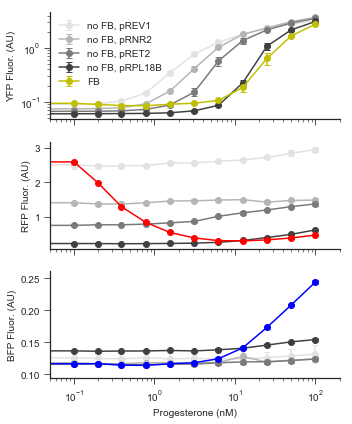

In [16]:
fig, ax = plt.subplots(3, 1,sharex=True,sharey='row',figsize=(5,6))

Greys = sns.color_palette('Greys',4)
Reds = sns.color_palette('Reds',6)
Blues = sns.color_palette('Blues',6)

for j, i in enumerate(promoters[0:4]):
    #Plot YFP values
    ax[0].errorbar(Pconc,FITCavg.loc[i,:],yerr = FITCstd.loc[i,:],capsize = 3,fmt = 'o-',color = Greys[j], label='no FB, '+i)

    #Plot RFP values
    ax[1].errorbar(Pconc,RFPavg.loc[i,:],yerr = RFPstd.loc[i,:],capsize = 3,fmt = 'o-',color = Greys[j],label='no FB, '+i)
    
    #Plot BFP values
    ax[2].errorbar(Pconc,BFPavg.loc[i,:],yerr = BFPstd.loc[i,:],capsize = 3,fmt = 'o-',color = Greys[j],label='no FB, '+i)
    
#Plot YFP values
ax[0].errorbar(Pconc,FITCavg.loc['CL',:],yerr = FITCstd.loc[i,:],capsize = 3,fmt = 'o-',color = 'y', label='FB')

#Plot RFP values
ax[1].errorbar(Pconc,RFPavg.loc['CL',:],yerr = RFPstd.loc[i,:],capsize = 3,fmt = 'o-',color = 'r',label='FB')

#Plot BFP values
ax[2].errorbar(Pconc,BFPavg.loc['CL',:],yerr = BFPstd.loc[i,:],capsize = 3,fmt = 'o-',color = 'b',label='FB')
   
ax[0].legend()
    
#ax[0,0].set_yscale('log')
ax[0].set_ylabel('YFP Fluor. (AU)')
ax[0].set_yscale('log')

ax[1].set_ylabel('RFP Fluor. (AU)')
#ax[1,0].set_yscale('log')

ax[2].set_ylabel('BFP Fluor. (AU)')
#ax[2,0].set_yscale('log')

ax[2].set_xlabel('Progesterone (nM)')
ax[2].set_xscale('log')
#ax[2].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'GEM_YRBcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()